In [48]:
import os, sys
sys.path.insert(1, '../')
import numpy as np
import pandas as pd
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely.ops import cascaded_union
import alphashape
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from  matplotlib.colors import LinearSegmentedColormap
from concentration import clt_swr, binomial_iid, bentkus_iid, wsr_iid, wsr_swr, clt_iid
from tqdm import tqdm
import seaborn as sns
import mapclassify as mc
import pdb

In [49]:
# Read raw data
raw_df = pd.read_csv('./data.csv')

In [50]:
# Process raw data
df = raw_df[raw_df.Year1 != 'tdo'].copy()
df.Year1 = df.Year1.astype(float)
epsilon = 0.3 # Tolerance for predictor

gt = (((df.Type1.astype(str) != 'nan') & ((df.Year1 >= 2000) & (df.Year1 <= 2015))) |
      ((df.Type2.astype(str) != 'nan') & ((df.Year2 >= 2000) & (df.Year2 <= 2015))) |
      ((df.Type3.astype(str) != 'nan') & ((df.Year3 >= 2000) & (df.Year3 <= 2015))) ).astype(float).to_numpy()

pred = ((df.tree_canopy_cover_2015/100 - df.tree_canopy_cover_2000/100) < -epsilon).astype(float).to_numpy()


print((pred-gt).std())
print((pred != gt).mean())
print(gt.std())
print((pred-gt).mean())
print(pred.mean())
print(gt.mean())
print((df.tree_canopy_cover_2015 - df.tree_canopy_cover_2000).mean())

0.31494530896813244
0.1080827067669173
0.361078434441702
-0.09429824561403509
0.05983709273182957
0.15413533834586465
-1.3559218559218562


In [51]:
# Colormap
c = ["darkred","red","lightcoral","white", "palegreen","green","darkgreen"]
v = [0,.15,.4,.6,0.7,.9,1.]
l = list(zip(v,c))
cmap=LinearSegmentedColormap.from_list('gr',l, N=256)

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude)
)

sa = gpd.read_file("./shapefiles/s-america.shp").reset_index()[["geometry"]] # Read shapefile of S. America

gdf["forest cover lost (%)"] = np.nan_to_num(gdf["tree_canopy_cover_2015"] - gdf["tree_canopy_cover_2000"])/100

gdf_small = gdf.sample(n=500).reset_index()#[["forest cover lost (%)", "geometry"]]
alpha_shape = alphashape.alphashape(gdf_small)
clipGDF = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[alpha_shape])

/Users/angelopoulos/miniconda3/lib/python3.9/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)
/Users/angelopoulos/miniconda3/lib/python3.9/site-packages/shapely/ops.py:42: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  source = iter(source)
/Users/angelopoulos/miniconda3/lib/python3.9/site-packages/alphashape/optimizealpha.py:41: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return all([polygon.intersects(point) for point in points])


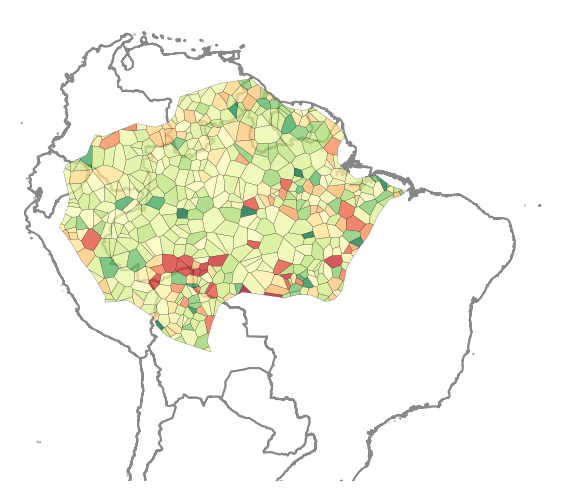

In [52]:
base = sa.plot(color='#FFFFFF', edgecolor='#888888', linewidth=2, figsize=(10,10));

scheme = mc.NaturalBreaks(gdf_small["forest cover lost (%)"], k=30)

vor = gplt.voronoi(
    gdf_small, 
    projection=None,
    hue='forest cover lost (%)',
    scheme=scheme, 
    cmap='RdYlGn',
    legend=False,
    ax=base,
    alpha=0.75,
    linewidth=0.25,
    clip = clipGDF,
)

plt.xlim(-83,-30)
plt.ylim(-30,15)
plt.savefig('./map.png', dpi=500, bbox_inches='tight')

In [53]:
# Problem setup
ns = np.array([10,25,50,100,200,300,500,750,1000,1500])
N = gt.shape[0]
num_trials = 100
alpha = 0.1
true_mean = gt.mean()
thetaf = pred.mean()

In [54]:
lengths = np.zeros((ns.shape[0],num_trials,2))
lower_endpoints = np.zeros((ns.shape[0],num_trials,2))
upper_endpoints = np.zeros((ns.shape[0],num_trials,2))
covereds = np.zeros((ns.shape[0],num_trials,2))
with np.errstate(divide='ignore', invalid='ignore'):
    for j in range(ns.shape[0]):
        for i in tqdm(range(num_trials)):
            n = ns[j]
            labeled = np.random.permutation(N)[:n]
            l_pred, l_gt = pred[labeled], gt[labeled]

            # Run Prediction-Powered Inference
            R = clt_iid((l_gt-l_pred+1)/2, alpha)*2 - 1
            C = R + thetaf
            lengths[j,i,0] = C[1]-C[0]
            covereds[j,i,0] = (true_mean >= C[0]) & (true_mean <= C[1])
            lower_endpoints[j,i,0] = C[0]
            upper_endpoints[j,i,0] = C[1]


            # Run Classical
            C_classical = clt_iid(l_gt, alpha)
            lengths[j,i,1] = C_classical[1] - C_classical[0]
            covereds[j,i,1] = (true_mean >= C_classical[0]) & (true_mean <= C_classical[1])
            lower_endpoints[j,i,1] = C_classical[0]
            upper_endpoints[j,i,1] = C_classical[1]

100%|███████████████████████████████████████| 100/100 [00:00<00:00, 5523.76it/s]


[0.75545283 0.81595109 0.85714588 0.86218483 0.87862011 0.87163104
 0.87513245 0.87116676 0.87215323 0.87363139]


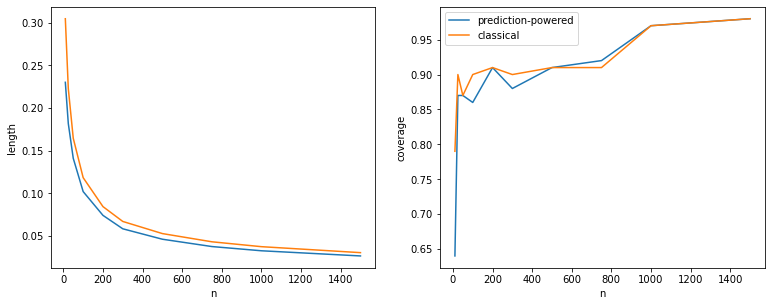

In [55]:
fig, axs = plt.subplots(ncols=2,figsize=(6.4*2,4.8))
axs[0].plot(ns, lengths.mean(axis=1))
axs[0].set_ylabel('length')
axs[0].set_xlabel('n')
axs[1].plot(ns, covereds.mean(axis=1))
axs[1].legend(["prediction-powered", "classical"])
axs[1].set_ylabel('coverage')
axs[1].set_xlabel('n')
mu_length = lengths.mean(axis=1)
print(mu_length[:,0]/mu_length[:,1])

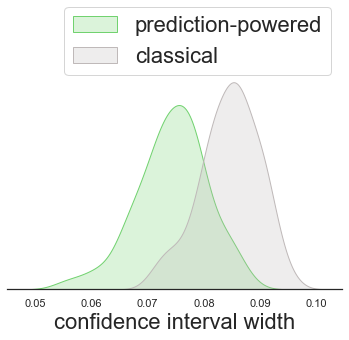

In [56]:
# Width kdeplot
n_idx = 4
estimator = np.array(num_trials*['prediction-powered'] + num_trials*['classical'])
width = np.concatenate([lengths[n_idx,:,0],lengths[n_idx,:,1]]) # n = 100
kde_df = pd.DataFrame(np.stack([estimator,width],axis=1), columns=["estimator", "width"])
kde_df["width"] = kde_df["width"].astype(float)

# Make plot
my_palette = sns.color_palette(["#BFB9B9","#71D26F"], 2)
plt.figure()
sns.set_theme(style="white", palette=my_palette)
kde = sns.kdeplot(kde_df, x="width", hue="estimator", hue_order=[ "classical","prediction-powered"], fill=True, clip=(0,None))
plt.gca().set_ylabel("")
plt.gca().set_xlabel("confidence interval width", fontsize=22)
plt.gca().set_yticks([])
plt.gca().set_yticklabels([])
sns.despine(ax=plt.gca(),top=True,right=True,left=True)
kde.get_legend().remove()
plt.gca().legend(["prediction-powered", "classical"], fontsize=22, bbox_to_anchor=(1,1.35))
plt.savefig('./widths.pdf', bbox_inches='tight')

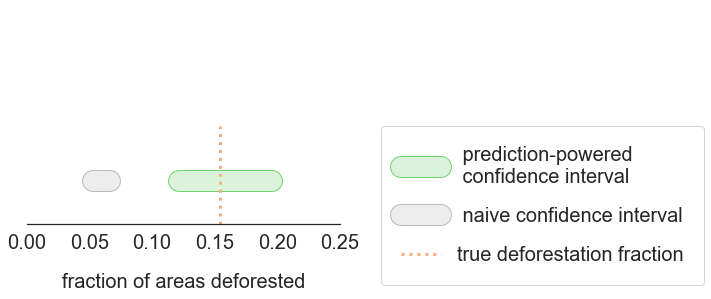

In [63]:
# Make plot
pp_interval_avg = [lower_endpoints[n_idx].mean(axis=0)[0], upper_endpoints[n_idx].mean(axis=0)[0]]
naive_interval = clt_iid(pred, alpha)
xlim = [0,0.25]
plt.figure()
sns.set_theme(style="white")
plt.plot([pp_interval_avg[0], pp_interval_avg[1]],[0.2,0.2], linewidth=20, color="#DAF3DA", path_effects=[pe.Stroke(linewidth=22, foreground="#71D26F"), pe.Normal()], label=' prediction-powered\n confidence interval')
plt.plot([naive_interval[0], naive_interval[1]],[0.2, 0.2], linewidth=20, color="#EEEDED", path_effects=[pe.Stroke(linewidth=22, foreground="#BFB9B9"), pe.Normal()], label=' naive confidence interval')
plt.gca().set_xlabel("fraction of areas deforested", fontsize=20, labelpad=20)
plt.gca().set_yticks([])
plt.gca().set_yticklabels([])
plt.gca().xaxis.set_tick_params(labelsize=20)
plt.ylim([0,1])
plt.xlim(xlim)
    
plt.vlines(true_mean, ymin=0.0, ymax=0.45, linestyle="dotted", linewidth=3, label="true deforestation fraction", color="#F7AE7C")
    
leg = plt.legend(fontsize=20, borderpad=1, labelspacing = 1, bbox_to_anchor=[1.1,0.5])
sns.despine(ax=plt.gca(),top=True,right=True,left=True)
plt.gcf().subplots_adjust(right=0.85)

plt.savefig('./intervals.pdf', bbox_inches='tight')